# Predicting Cab Cancellation
This dataset is taken from the kaggle competetion https://inclass.kaggle.com/c/predicting-cab-booking-cancellations/data

In [52]:
# load packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

# Setting the ast_node_interactivity to "all" will print
# each statement, not only the last one of a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# geopy
import geopy

# imbalanced learning
import imblearn

# matplotlib settings
matplotlib.style.use('seaborn')

# to compute the direct distance
from geographiclib.geodesic import Geodesic
import math
geod = Geodesic.WGS84  # define the WGS84 ellipsoid

# classes to inherit from for custom pipeline classes
from sklearn.base import TransformerMixin, BaseEstimator

## Load Data

In [53]:
df = pd.read_csv("data/Kaggle_YourCabs_training.csv")
df.head()
df.info()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 20 columns):
id                     43431 non-null int64
user_id                43431 non-null int64
vehicle_model_id       43431 non-null int64
package_id             7550 non-null float64
travel_type_id         43431 non-null int64
from_area_id           43343 non-null float64
to_area_id             34293 non-null float64
from_city_id           16345 non-null float64
to_city_id             1588 non-null float64
from_date              43431 non-null object
to_date                25541 non-null float64
online_booking         43431 non-null int64
mobile_site_booking    43431 non-null int64
booking_created        43431 non-null object
from_lat               43338 non-null float64
from_long              43338 non-null float64
to_lat                 34293 non-null float64
to_long                34293 non-null float64
Car_Cancellation       43431 non-null int64
Cost_of_error          43431 non-nu

## Explanation to the different attributes

* **id** - booking ID
* **user_id** - the ID of the customer (based on mobile number)
* **vehicle_model_id** - vehicle model type.
* **package_id** - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms)
* **travel_type_id** - type of travel (1=long distance, 2= point to point, 3= hourly rental).
* **from_area_id** - unique identifier of area. Applicable only for point-to-point travel and packages
* **to_area_id** - unique identifier of area. Applicable only for point-to-point travel
* **from_city_id** - unique identifier of city
* **to_city_id** - unique identifier of city (only for intercity)
* **from_date** - time stamp of requested trip start
* **to_date** - time stamp of trip end
* **online_booking** - if booking was done on desktop website
* **mobile_site_booking** - if booking was done on mobile website
* **booking_created** - time stamp of booking
* **from_lat** - latitude of from area
* **from_long** -  longitude of from area
* **to_lat** - latitude of to area
* **to_long** - longitude of to area
* **Car_Cancellation** (available only in training data) - whether the booking was cancelled (1) or not (0) due to unavailability of a car.
* **Cost_of_error** (available only in training data) - the cost incurred if the booking is misclassified. For an un-cancelled booking, the cost of misclassificaiton is 1. For a cancelled booking, the cost is a function of the cancellation time relative to the trip start time (see Evaluation Page).

A lot of missing values in **to_date, to_lat, to_long, from_city_id, to_city_id, to_area_id, package_id**

# transform timestamps from string to datetype object

In [85]:
# list of temporal features
temp_features = ['from_date', 'to_date', 'booking_created']
#temp_features = ['from_date']

In [76]:
# inherit from if you do not need a custom fit function
class NoFit:
    def fit(self, df, y=None):
        return self

# custom transformer 'column selector'
class ColumnSelector(TransformerMixin, NoFit):
    
    def __init__(self,cols):
        self.cols = cols
        
    def transform(self, df):
        df_cols = df[self.cols]
        return df_cols
        
#.astype('category', categories= list(set(X[col].values.tolist())))
# custom datatype transformer
class DataTypeTransformer(TransformerMixin, NoFit):
    
    def __init__(self, dataType, copy=True):
        self.copy = copy
        self.dataType = dataType
        
    def transform(self, df):
        df_ = df if not self.copy else df.copy()
        if self.dataType == 'category':
            return df_.astype('category', categories= list(set(df_.values.tolist())))
        if self.dataType == 'dateTime':
            for element in df_.columns.tolist():
                df_[element] = pd.to_datetime(df_[element])
            return df_
        else:
            return df_.astype(dataType)

In [86]:
# test pipeline objects
getTempCols = ColumnSelector(temp_features)
toDateTime = DataTypeTransformer('dateTime')

In [87]:
test = getTempCols.fit_transform(df)

In [88]:
toDateTime.fit_transform(test).head()

,from_date,to_date,booking_created
0,2013-01-01 02:00:00,NaT,2013-01-01 01:39:00
1,2013-01-01 09:00:00,NaT,2013-01-01 02:25:00
2,2013-01-01 03:30:00,NaT,2013-01-01 03:08:00
3,2013-01-01 05:45:00,NaT,2013-01-01 04:39:00
4,2013-01-01 09:00:00,NaT,2013-01-01 07:53:00


In [51]:
df['from_date'] = pd.to_datetime(df['from_date'])
df['to_date'] = pd.to_datetime(df['to_date'])
df['booking_created'] = pd.to_datetime(df['booking_created'])

In [258]:
df['test'] = df['from_date'] - df['booking_created']

In [300]:
df['diff_booking_from_date'] = df.apply(lambda x: int(x['test'].total_seconds() / 60), axis=1)

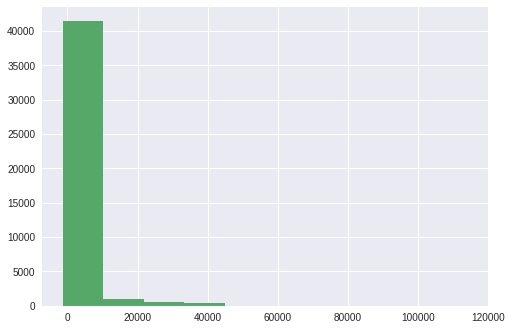

In [311]:
df.diff_booking_from_date.hist()
plt.show()

In [309]:
# weird time
df[df.diff_booking_from_date < 0][['from_date', 'booking_created']]

,from_date,booking_created
1763,2013-01-20 14:15:00,2013-01-20 15:01:00
2990,2013-02-01 09:45:00,2013-02-01 13:18:00
4228,2013-02-13 18:00:00,2013-02-13 18:29:00
5303,2013-02-23 18:00:00,2013-02-23 18:03:00
6106,2013-03-04 00:30:00,2013-03-04 02:00:00
6284,2013-03-06 12:45:00,2013-03-06 12:52:00
6496,2013-03-08 18:30:00,2013-03-08 19:06:00
6934,2013-03-13 16:00:00,2013-03-13 16:37:00
7006,2013-03-14 12:30:00,2013-03-14 12:32:00
7318,2013-03-18 14:00:00,2013-03-18 14:42:00


In [265]:
df['test']

0        0 days 00:21:00
1        0 days 06:35:00
2        0 days 00:22:00
3        0 days 01:06:00
4        0 days 01:07:00
5        0 days 14:29:00
6        0 days 00:24:00
7        0 days 01:21:00
8        0 days 06:16:00
9        0 days 01:11:00
10       0 days 01:05:00
11       0 days 02:46:00
12       0 days 02:12:00
13       0 days 01:28:00
14       0 days 03:12:00
15       0 days 14:08:00
16       0 days 12:16:00
17      10 days 19:43:00
18       0 days 03:32:00
19       0 days 00:33:00
20       0 days 01:38:00
21       0 days 04:50:00
22       0 days 02:10:00
23       0 days 01:51:00
24       3 days 17:50:00
25       0 days 02:04:00
26       1 days 04:58:00
27       0 days 05:23:00
28       0 days 01:23:00
29       0 days 02:49:00
              ...       
43401    0 days 02:16:00
43402    0 days 04:38:00
43403    0 days 02:07:00
43404    0 days 16:54:00
43405    0 days 03:04:00
43406    0 days 03:27:00
43407   30 days 03:26:00
43408    0 days 03:24:00
43409    0 days 02:16:00


In [223]:
def get_timeOfDay(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'        

In [ ]:
3%2 = 1

In [243]:
# not exactly the seasons; maybe more elegant with modulus
def get_season(timestamp):
    month = timestamp.month
    if 3 <= month < 6:
        return 'spring'
    if 6 <= month < 9:
        return 'summer'
    if 9 <= month < 12:
        return 'fall'
    else:
        return 'winter'

In [349]:
# morning, afternoon, evening, night
df['from_timeOfDay'] = df['from_date'].apply(lambda x: get_timeOfDay(x))
df['from_season'] = df['from_date'].apply(lambda x: get_season(x))

# The day of the week with Monday=0, Sunday=6
df['from_weekday'] = df['from_date'].apply(lambda x: x.dayofweek)
#df['from_date'].apply(lambda x: (x.month, get_season(x)))
#df.apply(lambda x: x).head()
# winter, spring, summer, autmn (21.12-21.02, 3-5,6-8,9-11)
# Wochentag, Woche und Wochenende
# booking created
# difference between booking created and actual trip start

In [318]:
df['diff_booking_from_date'] = df['diff_booking_from_date'].apply(lambda x: np.nan if x < 0 else x)

In [319]:
df['diff_booking_from_date'].fillna(df.diff_booking_from_date.median(),inplace=True)

In [336]:
df['diff_booking_from_date_quantile'] = pd.qcut(df.diff_booking_from_date, 10, labels=False)

In [337]:
df.diff_booking_from_date_quantile.describe()

count    43431.000000
mean         4.496028
std          2.874772
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: diff_booking_from_date_quantile, dtype: float64

# compute distance

In [293]:
# direct distance
geod.Inverse(12.9241, 77.6723, 12.9273, 77.6358)['s12']

3976.6573894647668

In [294]:
df.iloc[6]

id                                            132519
user_id                                        22172
vehicle_model_id                                  12
package_id                                       NaN
travel_type_id                                     1
from_area_id                                     571
to_area_id                                       NaN
from_city_id                                      15
to_city_id                                       108
from_date                        2013-01-01 09:45:00
to_date                1970-01-01 00:00:00.000041275
online_booking                                     0
mobile_site_booking                                0
booking_created                  2013-01-01 09:21:00
from_lat                                     12.9519
from_long                                    77.6964
to_lat                                           NaN
to_long                                          NaN
Car_Cancellation                              

In [296]:
df['direct_distance'] = df.apply(lambda x: geod.Inverse( x['from_lat'], x['from_long'] ,
                                    x['to_lat'], x['to_long'] )['s12'] / 1000, axis=1)

In [297]:
df.direct_distance.describe()

count    34293.000000
mean        17.321903
std         10.412096
min          0.000000
25%          8.549388
50%         14.652147
75%         26.179700
max         59.538541
Name: direct_distance, dtype: float64

# transform categoritcal to categortical type

In [195]:
# no need to transform since all values are already numeric
#categorical_columns = ['travel_type_id', 'Car_Cancellation', '']

# Analyze dataset

In [190]:
# summary statistics
df.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
count,43431.000000,43431.000000,43431.00000,7550.000000,43431.000000,43343.000000,34293.000000,16345.000000,1588.000000,43431.000000,43431.000000,43338.000000,43338.000000,34293.000000,34293.000000,43431.000000,43431.000000
mean,159206.473556,30739.198153,25.71723,2.030066,2.137252,714.544494,669.490917,14.915081,68.537783,0.351592,0.043241,12.982461,77.636255,13.026648,77.640595,0.072114,8.000509
std,15442.386279,10996.476709,26.79825,1.461756,0.437712,419.883553,400.638225,1.165306,49.880732,0.477473,0.203402,0.085933,0.059391,0.113487,0.064045,0.258680,25.350698
min,132512.000000,16.000000,1.00000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930,0.000000,0.150000
25%,145778.000000,24614.000000,12.00000,1.000000,2.000000,393.000000,393.000000,15.000000,32.000000,0.000000,0.000000,12.926450,77.593661,12.951850,77.582030,0.000000,1.000000
50%,159248.000000,31627.000000,12.00000,2.000000,2.000000,590.000000,541.000000,15.000000,49.000000,0.000000,0.000000,12.968887,77.635750,12.982750,77.645030,0.000000,1.000000
75%,172578.500000,39167.000000,24.00000,2.000000,2.000000,1089.000000,1054.000000,15.000000,108.000000,1.000000,0.000000,13.007750,77.688900,13.199560,77.706880,0.000000,1.000000
max,185941.000000,48730.000000,91.00000,7.000000,3.000000,1403.000000,1403.000000,31.000000,203.000000,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420,1.000000,100.000000


In [191]:
# skewness
print("skewness (Schiefheit):")
df.groupby('Car_Cancellation').skew().transpose()

skewness (Schiefheit):


Car_Cancellation,0,1
Cost_of_error,0.000000,-6.680960
from_area_id,0.101981,0.011442
from_city_id,-9.527800,0.000000
from_lat,1.196998,1.299525
from_long,-0.119677,-0.600825
id,0.022582,-0.374764
mobile_site_booking,4.733281,2.818978
online_booking,0.714965,-0.440933
package_id,1.897191,1.053949
to_area_id,0.536899,0.035144


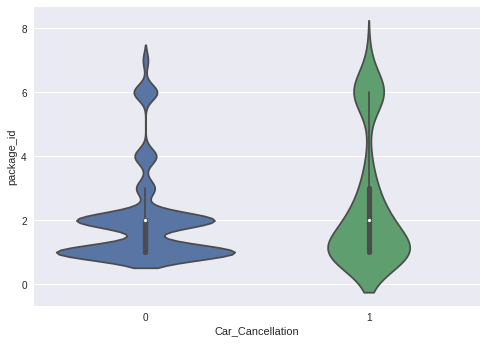

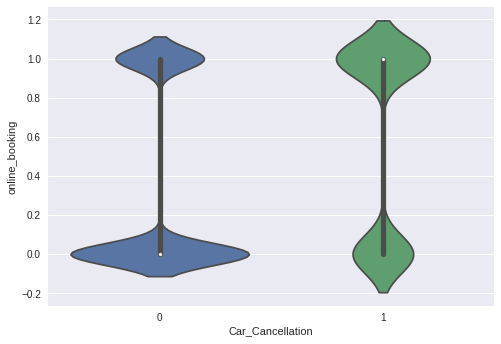

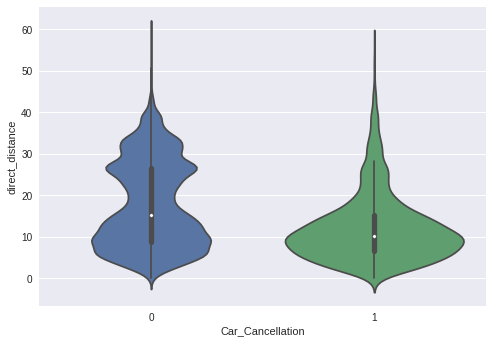

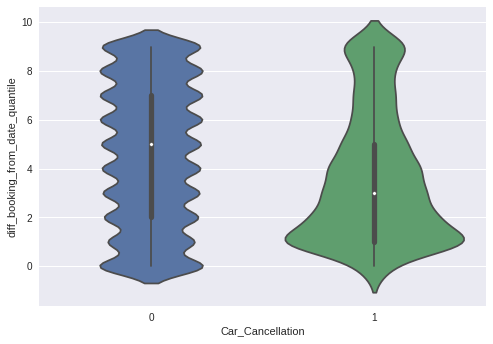

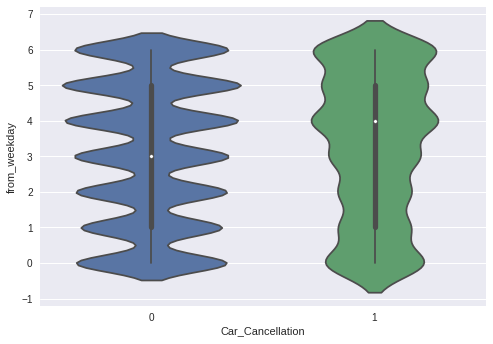

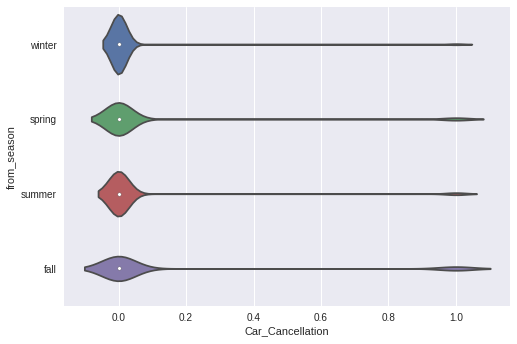

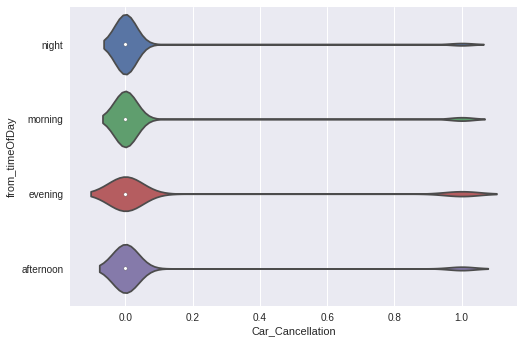

In [350]:
column_list = ['package_id', 'online_booking', 'direct_distance',
               'diff_booking_from_date_quantile', 'from_weekday', 'from_season', 'from_timeOfDay']

for element in column_list:
#    ax = sns.stripplot(data=df, y=element, x='Car_Cancellation',jitter=True, color='gray')
    ax = sns.violinplot(data=df, y=element, x='Car_Cancellation', inner='box')
    plt.show()

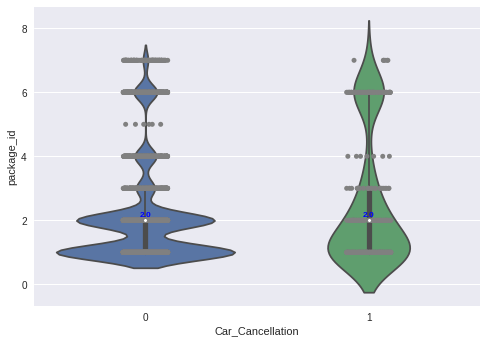

In [108]:
plt.show()

In [78]:
df.hist(by='Car_Cancellation', column='package_id')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f43f09764e0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f443b107cf8>], dtype=object)

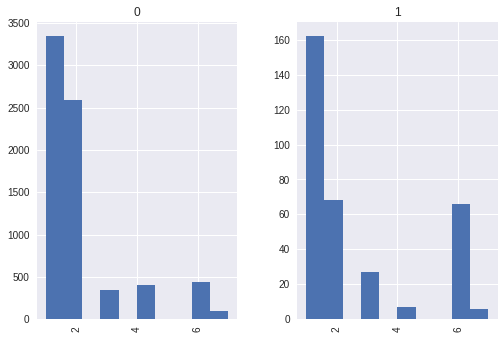

In [79]:
plt.show()

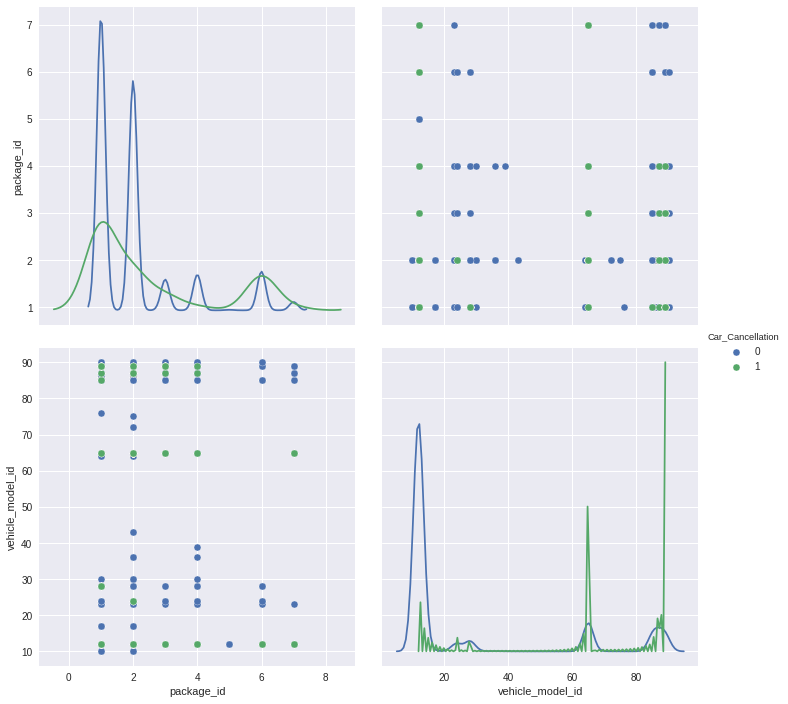

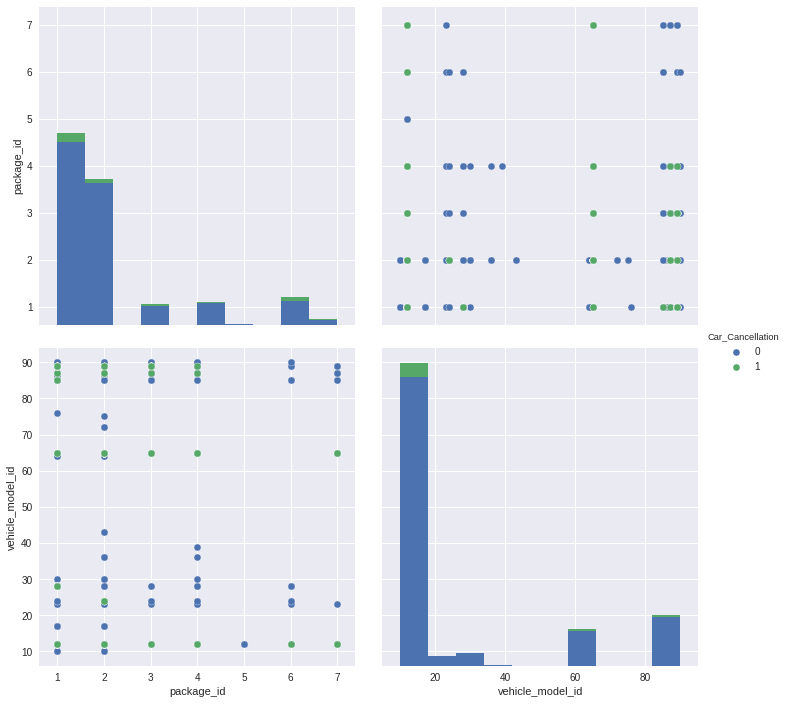

In [139]:
plt.show()

In [82]:
medians

array([ 2.,  2.])

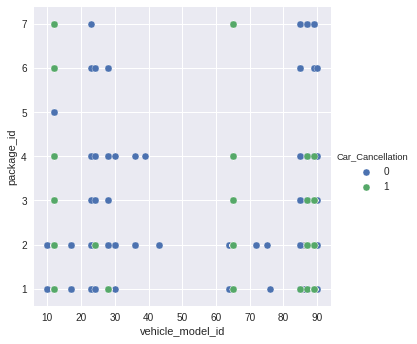

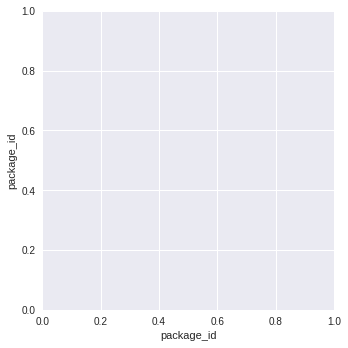

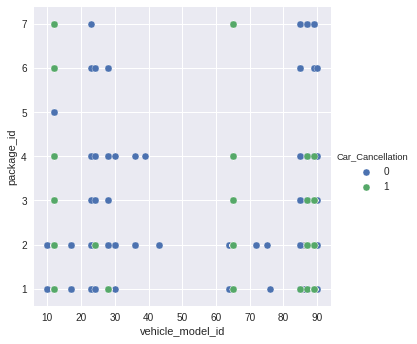

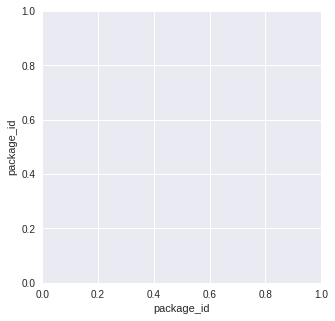

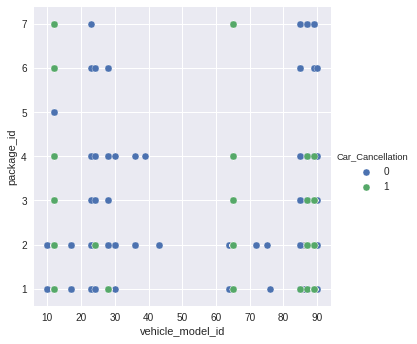

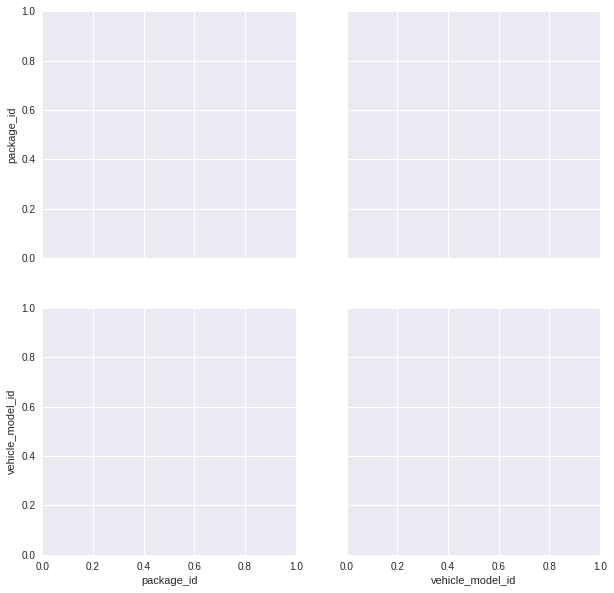

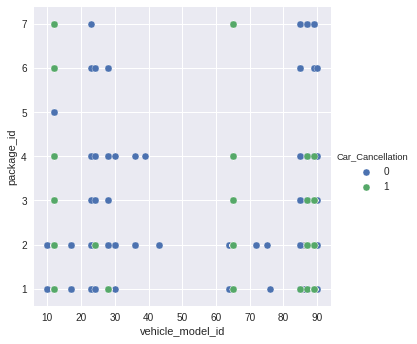

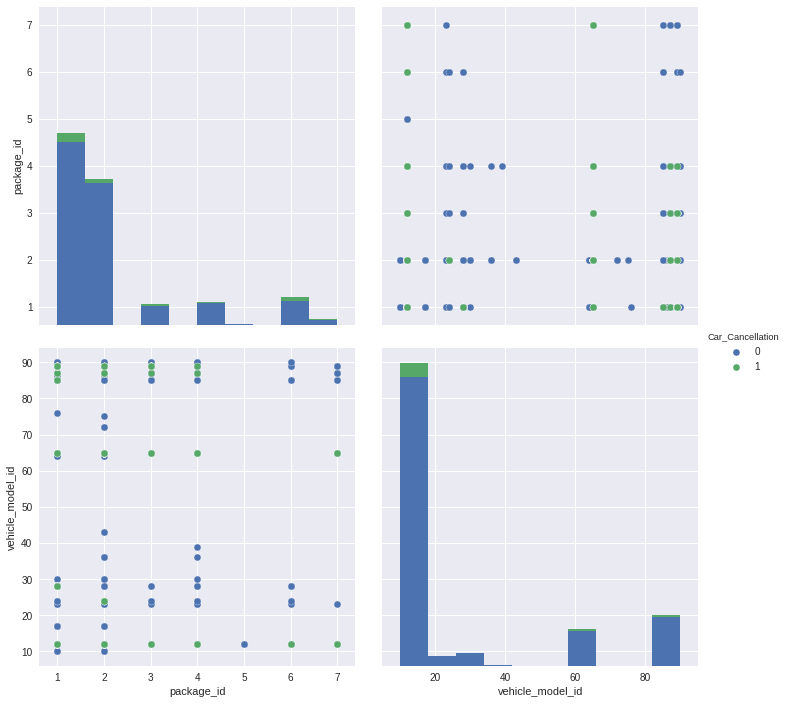

In [15]:
plt.show()

<bound method Artist.get_figure of <matplotlib.axes._subplots.AxesSubplot object at 0x7f8f8058f5f8>>

In [346]:
df.from_city_id.unique()
df.to_city_id.unique()

array([ nan,  15.,   1.,  31.])

array([  nan,  108.,   32.,  152.,   29.,  160.,   64.,   61.,  146.,
         13.,  179.,  131.,   55.,   31.,   24.,  189.,  147.,  187.,
         65.,  178.,   49.,  185.,  161.,  126.,   56.,   41.,   68.,
         58.,   36.,  135.,  144.,  163.,  151.,   25.,  191.,    4.,
        162.,  114.,  203.,   44.,  157.,   37.,  115.,   51.,  190.,
         77.,  109.,   45.,   16.,  116.,   10.,  154.,  198.,   66.,
        167.,  110.,  113.,  119.,  170.,  184.,   17.,   60.,   42.,
         82.,   69.,    8.,   97.,   89.,   62.,   67.,   76.,  148.,
         20.,  137.,   85.,  192.,  125.,  168.,  132.,  172.,  164.,
        149.,   75.,   11.,  121.,   57.,   28.,   12.,   80.,  134.,
         14.,  176.,   88.,  169.,   48.,  139.,   30.,  133.,   94.,
        200.,  142.,  165.,   72.,    5.,  173.,  186.,   53.,  182.,
        196.,   18.,  120.,  197.,  166.,  111.,   52.,   23.,   50.])

In [347]:
df.nunique()

id                                 43431
user_id                            22267
vehicle_model_id                      27
package_id                             7
travel_type_id                         3
from_area_id                         598
to_area_id                           568
from_city_id                           3
to_city_id                           116
from_date                          20377
to_date                              347
online_booking                         2
mobile_site_booking                    2
booking_created                    39349
from_lat                             466
from_long                            462
to_lat                               450
to_long                              447
Car_Cancellation                       2
Cost_of_error                         70
test                                7035
direct_distance                     7891
diff_booking_from_date              7001
diff_booking_from_date_quantile       10
from_weekday    

In [11]:
df.from_area_id.nunique()
df.to_area_id.nunique()

598

568

In [12]:
df.from_city_id.unique()

array([ nan,  15.,   1.,  31.])

In [17]:
df.to_city_id.unique()

array([  nan,  108.,   32.,  152.,   29.,  160.,   64.,   61.,  146.,
         13.,  179.,  131.,   55.,   31.,   24.,  189.,  147.,  187.,
         65.,  178.,   49.,  185.,  161.,  126.,   56.,   41.,   68.,
         58.,   36.,  135.,  144.,  163.,  151.,   25.,  191.,    4.,
        162.,  114.,  203.,   44.,  157.,   37.,  115.,   51.,  190.,
         77.,  109.,   45.,   16.,  116.,   10.,  154.,  198.,   66.,
        167.,  110.,  113.,  119.,  170.,  184.,   17.,   60.,   42.,
         82.,   69.,    8.,   97.,   89.,   62.,   67.,   76.,  148.,
         20.,  137.,   85.,  192.,  125.,  168.,  132.,  172.,  164.,
        149.,   75.,   11.,  121.,   57.,   28.,   12.,   80.,  134.,
         14.,  176.,   88.,  169.,   48.,  139.,   30.,  133.,   94.,
        200.,  142.,  165.,   72.,    5.,  173.,  186.,   53.,  182.,
        196.,   18.,  120.,  197.,  166.,  111.,   52.,   23.,   50.])